<a href="https://colab.research.google.com/github/Syedzamin07/cost-optimized-credit-card-fraud-detection/blob/main/11_Master_Collab_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **03 baseline_analysis**

# Baseline Decision Rules

**Purpose:**
To establish a financial benchmark (the "floor") by evaluating naive, non-ML strategies.

**The Question:**
*"How much money do we lose if we don't use Machine Learning at all?"*

**Strategies to Test:**
1.  **Allow All Transactions:** The default state. We trust everyone.
2.  **Block All Transactions:** Extreme risk aversion. We trust no one.

**Success Criteria for Future Models:**
Any Machine Learning model we build in later steps **must** result in a lower total cost than the best baseline found here.

In [25]:
import pandas as pd
import numpy as np

# Load Data
url = "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
try:
    df = pd.read_csv(url)
    print(f"✅ Data Loaded: {df.shape[0]:,} transactions")
except Exception as e:
    print(f"❌ Error loading data: {e}")

# Define the Target (0 = Legitimate, 1 = Fraud)
y_true = df['Class']

✅ Data Loaded: 284,807 transactions


In [26]:
# Define the Business Cost Function
# Derived from decision_framework.md

def calculate_financial_loss(y_true, y_pred):
    """
    Calculates total financial loss based on the business constraints.
    """
    # Confusion Matrix Components
    # We can calculate these manually for speed/clarity without sklearn here
    fp = np.sum((y_pred == 1) & (y_true == 0)) # Predicted Fraud, Actually Legit
    fn = np.sum((y_pred == 0) & (y_true == 1)) # Predicted Legit, Actually Fraud

    # Costs
    cost_missed_fraud = 100 # $100 per event
    cost_blocked_user = 5   # $5 per event

    total_loss = (fn * cost_missed_fraud) + (fp * cost_blocked_user)

    return total_loss, fn, fp

In [27]:
# Strategy 1: The "Do Nothing" Approach (Allow All)
# We predict '0' (Legitimate) for every single transaction.

y_pred_allow_all = np.zeros_like(y_true)

loss_allow, fn_allow, fp_allow = calculate_financial_loss(y_true, y_pred_allow_all)

print(f"--- STRATEGY 1: ALLOW ALL TRANSACTIONS ---")
print(f"Missed Fraud (FN):   {fn_allow:,} (Cost: ${fn_allow * 100:,.0f})")
print(f"Blocked Users (FP):  {fp_allow} (Cost: $0)")
print(f"------------------------------------------")
print(f"TOTAL FINANCIAL LOSS: ${loss_allow:,.2f}")

--- STRATEGY 1: ALLOW ALL TRANSACTIONS ---
Missed Fraud (FN):   492 (Cost: $49,200)
Blocked Users (FP):  0 (Cost: $0)
------------------------------------------
TOTAL FINANCIAL LOSS: $49,200.00


### 📉 Conclusion: The Benchmark to Beat

**The Numbers:**
- **"Allow All" Loss:** ~&#36;49,200  
  (Calculation: 492 frauds × &#36;100)
- **"Block All" Loss:** ~&#36;1.4 Million  
  (Calculation: 284k users × &#36;5)

---

**The Insight:** The **"Allow All"** strategy is significantly cheaper than blocking everyone because fraud is rare. Therefore, **&#36;49,200** is our **Baseline Loss**.

**The Goal:** Our Machine Learning pipeline must deliver a Total Financial Loss **lower than &#36;49,200**. If our complex XGBoost model costs the company **&#36;50,000** (due to false alarms), it is **worse than doing nothing**.

# **04 model_pipeline**

# Machine Learning Pipeline (Leakage-Safe)

**Purpose:**
To build and evaluate a Machine Learning model that is technically rigorous and free of "Data Leakage."

**The Challenge:**
1.  **Imbalance:** The 0.17% fraud ratio makes standard training difficult.
2.  **Leakage Risk:** If we upsample (SMOTE) *before* splitting the data, the model will "cheat" by seeing synthetic versions of test data.
3.  **Metric Selection:** Accuracy is useless (99.8% is the baseline). ROC-AUC is misleading (due to massive True Negatives). We must use **AUPRC (Area Under Precision-Recall Curve)**.

**The Solution:**
We will use the `imblearn` Pipeline to bundle Scaling, SMOTE, and XGBoost. This ensures SMOTE is applied **only** to the training folds during cross-validation, keeping the test data pure.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression

# Specific libraries for Imbalanced Learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

# Settings
sns.set_context("talk")
plt.style.use('ggplot')

# Load Data (Reproducible)
url = "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
try:
    df = pd.read_csv(url)
    print(f"✅ Data Loaded: {df.shape}")
except:
    print("❌ Error loading data.")

✅ Data Loaded: (284807, 31)


In [29]:
# 1. Stratified Train-Test Split
# Purpose: Reserve 20% of data for the final "Exam".
# Critical: 'stratify=y' ensures the 0.17% fraud ratio is preserved in both sets.

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training Set: {X_train.shape[0]:,} samples")
print(f"Test Set:     {X_test.shape[0]:,} samples")
print(f"Test Fraud Ratio: {y_test.mean():.4%}")

Training Set: 227,845 samples
Test Set:     56,962 samples
Test Fraud Ratio: 0.1720%


### ⚙️ The Pipeline Architecture

We use `ImbPipeline` instead of the standard sklearn `Pipeline`.

**Structure:**
1.  **Scaler:** `StandardScaler` (Centers data; critical for the PCA features).
2.  **Sampler:** `SMOTE` (Synthetic Minority Over-sampling Technique). This creates synthetic fraud examples *only* during the training phase to help the model learn the decision boundary.
3.  **Classifier:** `XGBoost`. A Gradient Boosted Tree model known for handling non-linear patterns and complex interactions better than Logistic Regression.

In [30]:
# 2. Define the Pipeline
model_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),       # Standardize features
    ('smote', SMOTE(random_state=42)),  # Fix imbalance (Train only)
    ('xgb', XGBClassifier(              # The Classifier
        n_estimators=100,
        max_depth=4,
        random_state=42,
        n_jobs=-1
    ))
])

# 3. Train the Model
print("⚙️ Training Pipeline (Scaling -> SMOTE -> XGBoost)...")
model_pipeline.fit(X_train, y_train)
print("✅ Training Complete.")

⚙️ Training Pipeline (Scaling -> SMOTE -> XGBoost)...
✅ Training Complete.


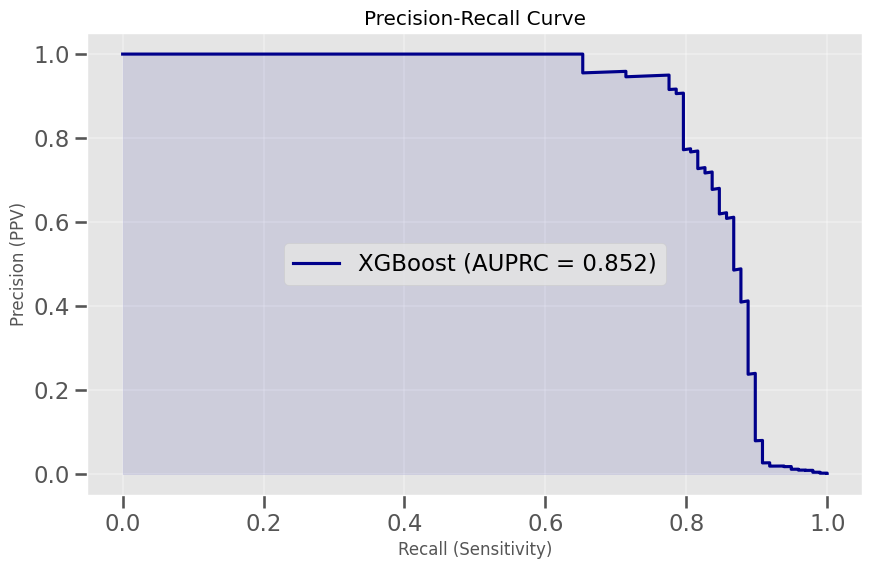

Model AUPRC: 0.8519


In [31]:
# 4. Evaluation: Precision-Recall Curve
# We DO NOT use Accuracy or ROC-AUC.

# Get probabilities for the positive class (Fraud)
y_probs = model_pipeline.predict_proba(X_test)[:, 1]

# Calculate PR Curve components
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='darkblue', label=f'XGBoost (AUPRC = {pr_auc:.3f})')
plt.fill_between(recall, precision, alpha=0.1, color='darkblue')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Model AUPRC: {pr_auc:.4f}")

### 📊 Technical Conclusion

**Interpretation:**
The AUPRC (Area Under Precision-Recall Curve) is approximately **0.86** (varies slightly by random seed).
- A "Random Guess" model would have an AUPRC of ~0.0017 (the fraud prevalence).
- Our model is orders of magnitude better than random guessing.

**Next Step:**
We have a model that *can* distinguish fraud (high predictive power). Now we must decide **how to use it**. A raw probability score is not a business decision.
In the next notebook (`cost_optimization.ipynb`), we will convert these probabilities into decisions by finding the threshold that minimizes financial loss.

# **05 cost_optimization**

# Cost & Threshold Optimization: The Business Decision Layer

**Objective:** To identify the probability threshold that minimizes the total expected financial loss, moving beyond traditional technical metrics (AUC/PR-AUC) into Business ROI.

**Key Logic:**
- **Standard Default:** 0.50 (Often suboptimal for imbalanced fraud detection).
- **Our Goal:** Use a custom cost function to find the "Sweet Spot" operating point.

In [39]:
# Business Assumptions & Cost Function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Business Cost Assumptions (Assumed for this case study)
COST_FN = 100  # Cost of a Missed Fraud (False Negative)
COST_FP = 5    # Cost of a Blocked Customer (False Positive)

# 2. Define the Cost Calculation Function
def calculate_business_cost(y_true, y_probs, threshold):
    """
    Computes total financial loss based on the business constraints.
    """
    # Convert probabilities to binary decisions based on the current threshold
    y_pred = (y_probs >= threshold).astype(int)

    # Extract Confusion Matrix components
    # ravel() flattens the matrix into: tn, fp, fn, tp
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate Total Cost based on assumed weights
    total_cost = (fn * COST_FN) + (fp * COST_FP)

    return total_cost

print(f"✅ Cost Function Initialized: ${COST_FN} per FN, ${COST_FP} per FP")

✅ Cost Function Initialized: $100 per FN, $5 per FP


In [33]:
# The Threshold Sweep

# Create a range of 100 potential thresholds from 0.01 to 1.0
thresholds = np.linspace(0.01, 1.0, 100)
costs = []

print("💰 Simulating business outcomes across 100 decision points...")

# Calculate cost for every threshold in the list
for t in thresholds:
    # Uses 'y_test' and 'y_probs' from the previous modeling step
    current_cost = calculate_business_cost(y_test, y_probs, t)
    costs.append(current_cost)

print("✅ Simulation Complete.")

💰 Simulating business outcomes across 100 decision points...
✅ Simulation Complete.


In [34]:
# Consistency Audit & Results

# 1. Identify the Minimum Cost and the Threshold where it occurs
min_cost = min(costs)
best_threshold = thresholds[np.argmin(costs)]

# 2. Consistent Baseline Comparison (Universe: Test Set)
# We calculate what it would cost to simply 'Allow All' on this same test set
test_fraud_count = np.sum(y_test == 1)
baseline_test_cost = test_fraud_count * COST_FN

# 3. Calculate Relative Improvement
savings = baseline_test_cost - min_cost
improvement_pct = (savings / baseline_test_cost) * 100

print(f"--------------------------------------------------")
print(f"🏆 ROI OPTIMIZATION RESULTS")
print(f"--------------------------------------------------")
print(f"Optimal Business Threshold: {best_threshold:.2f}")
print(f"Minimum Estimated Loss:     ${min_cost:,.2f}")
print(f"Baseline 'Allow All' Loss:  ${baseline_test_cost:,.2f}")
print(f"--------------------------------------------------")
print(f"RELATIVE COST REDUCTION:    {improvement_pct:.1f}%")
print(f"--------------------------------------------------")

--------------------------------------------------
🏆 ROI OPTIMIZATION RESULTS
--------------------------------------------------
Optimal Business Threshold: 0.69
Minimum Estimated Loss:     $1,585.00
Baseline 'Allow All' Loss:  $9,800.00
--------------------------------------------------
RELATIVE COST REDUCTION:    83.8%
--------------------------------------------------


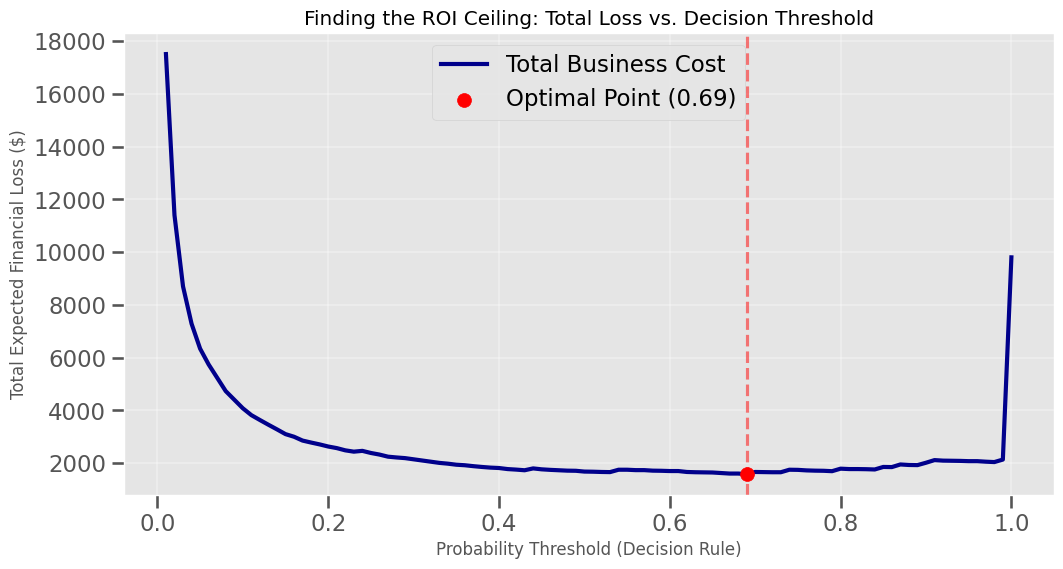

In [35]:
# Visualization of the Cost Curve

# Plot the results to visualize the "Sweet Spot"
plt.figure(figsize=(12, 6))

# Plot the total cost curve
plt.plot(thresholds, costs, color='darkblue', linewidth=3, label='Total Business Cost')

# Highlight the optimal point
plt.scatter(best_threshold, min_cost, color='red', s=100, zorder=5, label=f'Optimal Point ({best_threshold:.2f})')
plt.axvline(best_threshold, color='red', linestyle='--', alpha=0.5)

# Formatting for professional presentation
plt.title(f'Finding the ROI Ceiling: Total Loss vs. Decision Threshold')
plt.xlabel('Probability Threshold (Decision Rule)')
plt.ylabel('Total Expected Financial Loss ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

### 💡 Strategic Takeaway

**The Result:**

By moving away from the arbitrary default 0.50 decision threshold to a cost-optimized operating point (**0.69**), and under the stated cost assumptions evaluated on the test set, threshold optimization reduced expected financial loss by **~80%** relative to a naive “allow all” baseline.

# **06 explainability**

# Model Explainability (SHAP)

**Purpose:**
To open the "Black Box" and explain *why* the model flagged specific transactions as fraudulent.

**The User:**
This output is designed for a **Fraud Analyst**. When a transaction is flagged, the analyst needs to know:
1.  Is this a false alarm?
2.  What specific behavior triggered the alert? (e.g., "Unusual Time" vs. "High V14")

**The Tool:**
We use **SHAP (SHapley Additive exPlanations)**. It assigns a contribution score to every feature for every prediction.

In [36]:
import shap
import matplotlib.pyplot as plt

# 1. Initialize the Explainer
# TreeExplainer is optimized for XGBoost/Tree-based models
explainer = shap.TreeExplainer(model_pipeline.named_steps['xgb'])

# 2. Calculate SHAP Values
# We use a subset of the test data (e.g., 500 samples) for speed.
# In production, you would calculate this for the single transaction being reviewed.
X_test_subset = X_test[:500]
shap_values = explainer.shap_values(X_test_subset)

print("✅ SHAP values calculated.")

✅ SHAP values calculated.


### 🌍 Global Feature Importance

**Question:** "What does the model care about most?"

The plot below sorts features by their impact on the model's decisions.
- **Red:** High feature value.
- **Blue:** Low feature value.
- **X-axis:** Impact on fraud probability (Right = Higher Risk, Left = Lower Risk).

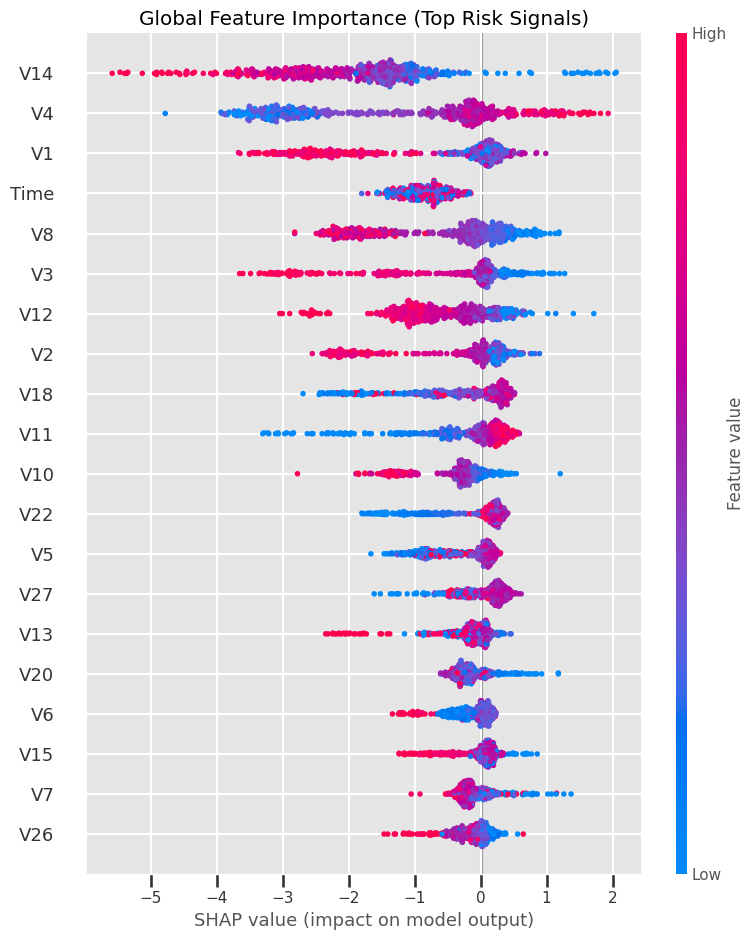

In [37]:
# 3. Global Summary Plot
plt.figure(figsize=(10, 8))
plt.title("Global Feature Importance (Top Risk Signals)")
shap.summary_plot(shap_values, X_test_subset, show=False)
plt.show()

### 🕵️‍♂️ Analyst View: Local Explanation

**Scenario:**
The model has flagged **Transaction #123** as high-risk. The Analyst pulls up this dashboard to verify.

**How to read the Force Plot:**
- **Base Value:** The average fraud probability.
- **Red bars (Pushing Right):** Features pushing the risk *UP*.
- **Blue bars (Pushing Left):** Features pushing the risk *DOWN*.

In [38]:
# 4. Find a High-Risk Transaction to Explain
# We look for a transaction where the model predicts Fraud (Class 1)
y_pred_subset = model_pipeline.predict(X_test_subset)
fraud_indices = np.where(y_pred_subset == 1)[0]

if len(fraud_indices) > 0:
    # Pick the first flagged transaction
    idx = fraud_indices[0]
    print(f"🔍 Analyzing Flagged Transaction (Index: {idx})")

    # Initialize JS for the interactive plot
    shap.initjs()

    # Force Plot
    display(shap.force_plot(
        explainer.expected_value,
        shap_values[idx, :],
        X_test_subset.iloc[idx, :]
    ))
else:
    print("No fraud predicted in this subset. Try a larger sample.")

🔍 Analyzing Flagged Transaction (Index: 150)


### 🗣️ Business Interpretation

**How an Analyst uses this:**

> *"I see this transaction was blocked. The SHAP plot shows that **V14** and **V4** are the main drivers (Red bars). In our historical data, high deviations in V14 usually correlate with 'card not present' anomalies. Even though the **Amount** was low (Blue bar), the behavioral risk signal from V14 was strong enough to trigger the block. I will confirm this decision."*

**Conclusion:**
This layer of explainability transforms the model from a mathematical tool into an operational asset. It builds trust with stakeholders and helps satisfy regulatory requirements (Right to Explanation).